<a href="https://colab.research.google.com/github/psj03283/oral-cancer/blob/main/PAP(07_04)_model_train_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [ ]:
!pip install -q tensorflow
!pip install efficientnet
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 33.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install keras-metrics

In [ ]:
import tensorflow as tf

In [ ]:
from tqdm import tqdm_notebook
ram=[]
for i in tqdm_notebook(range(100)):
  ram.append("randomword"*i)

/tmp/ipython-input-4-2252751400.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
#import tensorflow_addons as tfa
import openpyxl

In [ ]:
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get install fonts-crosextra-carlito


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-crosextra-caladea
The following NEW packages will be installed:
  fonts-crosextra-carlito
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 743 kB of archives.
After this operation, 2,798 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-crosextra-carlito all 20130920-1.1 [743 kB]
Fetched 743 kB in 1s (564 kB/s)
Selecting previously unselected package fonts-crosextra-carlito.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-crosextra-carlito_20130920-1.1_all.deb ...
Unpacking fonts-crosextra-carlito (20130920-1.1) ...
Setting up fonts-crosextra-carlito (20130920-1.1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


##**Training Data**

In [ ]:
SEED = 42
EPOCHS = 50
BATCH_SIZE = 16
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [ ]:
import keras_metrics as km

In [ ]:
os.makedirs("/content/drive/My Drive/pap_smear/metrics", exist_ok=True)
os.makedirs("/content/drive/My Drive/pap_smear/preds", exist_ok=True)
os.makedirs("/content/drive/My Drive/pap_smear/models", exist_ok=True)


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import efficientnet.tfkeras as efn

# -----------------------------
# ✅ Data pipeline helpers
# -----------------------------
def parse_function(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    image = image / 255.0
    return image, label

def numpy_rotate(image):
    image = image.numpy()
    angle = np.random.uniform(-10, 10)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return rotated.astype(np.float32)

def augment_function(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    do_rotate = tf.less(tf.random.uniform([], 0, 1.0), 0.5)

    def _rotate():
        rotated = tf.py_function(func=numpy_rotate, inp=[image], Tout=tf.float32)
        rotated.set_shape(image.shape)  # Very important!
        return rotated

    image = tf.cond(
        do_rotate,
        _rotate,
        lambda: image
    )

    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# -----------------------------
# ✅ Build your model
# -----------------------------
def build_model(img_height, img_width, n_channels):
    inp = Input(shape=(img_height, img_width, n_channels))
    base = efn.EfficientNetB0(
        input_shape=(img_height, img_width, n_channels),
        weights='imagenet',
        include_top=False
    )
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    out = Dense(4, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    return model

# -----------------------------
# ✅ Custom MetricsLogger callback (Option A)
# -----------------------------
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, val_labels, class_names, fold, out_csv):
        super(MetricsLogger, self).__init__()
        self.val_ds = val_ds
        self.val_labels = val_labels
        self.class_names = class_names
        self.fold = fold
        self.out_csv = out_csv
        self.df = pd.DataFrame(columns=['epoch','fold','metric','class','value'])

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        self.df.loc[len(self.df)] = [epoch+1, self.fold, 'loss', 'overall', val_loss]

        y_true = self.val_labels
        y_pred_probs = self.model.predict(self.val_ds, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_true, y_pred)
        self.df.loc[len(self.df)] = [epoch+1, self.fold, 'accuracy', 'overall', acc]

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(self.class_names)))
        for idx, class_name in enumerate(self.class_names):
            self.df.loc[len(self.df)] = [epoch+1, self.fold, 'precision', class_name, precision[idx]]
            self.df.loc[len(self.df)] = [epoch+1, self.fold, 'recall', class_name, recall[idx]]
            self.df.loc[len(self.df)] = [epoch+1, self.fold, 'f1', class_name, f1[idx]]

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        self.df.loc[len(self.df)] = [epoch+1, self.fold, 'precision', 'overall', precision_macro]
        self.df.loc[len(self.df)] = [epoch+1, self.fold, 'recall', 'overall', recall_macro]
        self.df.loc[len(self.df)] = [epoch+1, self.fold, 'f1', 'overall', f1_macro]

        y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(self.class_names))
        try:
            roc_auc_macro = roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr')
            self.df.loc[len(self.df)] = [epoch+1, self.fold, 'roc_auc', 'overall', roc_auc_macro]
            for idx, class_name in enumerate(self.class_names):
                roc_auc_class = roc_auc_score(y_true_onehot[:, idx], y_pred_probs[:, idx])
                self.df.loc[len(self.df)] = [epoch+1, self.fold, 'roc_auc', class_name, roc_auc_class]
        except:
            print(f"⚠️ Skipped ROC AUC at epoch {epoch+1} due to lack of class variation.")

        self.df.to_csv(self.out_csv, index=False)

    def on_train_end(self, logs=None):
        # ✅ Final predictions for McNemar's test
        y_true = self.val_labels
        y_pred_probs = self.model.predict(self.val_ds, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        val_preds_df = pd.DataFrame({
            'index': np.arange(len(y_true)),
            'true_label': y_true,
            'pred_label': y_pred
        })

        val_preds_df.to_csv(
            f'/content/drive/My Drive/pap_smear/preds/fold{self.fold}_preds_E.csv',
            index=False
        )
        print(f"✅ Saved final val predictions for fold {self.fold}")

# -----------------------------
# ✅ Loop over folds
# -----------------------------
base_path = "/content/drive/My Drive/pap_smear/folds"
class_names = ['NILM', 'LSIL', 'HSIL', 'SCC']

BUFFER_SIZE = 1000
BATCH_SIZE = 16

for fold in range(1, 5):
    print(f"\n📂 Starting Fold {fold}")

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    for class_label in ['0', '1', '2', '3']:
        train_glob = glob.glob(os.path.join(base_path, f"fold{fold}_E/train/{class_label}/*"))
        val_glob = glob.glob(os.path.join(base_path, f"fold{fold}_E/val/{class_label}/*"))
        train_paths.extend(train_glob)
        val_paths.extend(val_glob)
        train_labels.extend([int(class_label)] * len(train_glob))
        val_labels.extend([int(class_label)] * len(val_glob))

    train_ds = (
        tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
        .shuffle(BUFFER_SIZE)
        .map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        .map(augment_function, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    val_ds = (
        tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
        .map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    model = build_model(512, 512, 3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    metrics_logger = MetricsLogger(
        val_ds=val_ds,
        val_labels=np.array(val_labels),
        class_names=class_names,
        fold=fold,
        out_csv = f"/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[reduce_lr, early_stop, metrics_logger],
        verbose=1
    )

    model.save(f"/content/drive/My Drive/pap_smear/models/model_fold{fold}_E.h5")
    print(f"✅ Finished Fold {fold}")



📂 Starting Fold 1
16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.4087 - loss: 1.3317 - val_accuracy: 0.2241 - val_loss: 1.3849 - learning_rate: 1.0000e-05
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.5998 - loss: 1.1807 - val_accuracy: 0.3112 - val_loss: 1.3207 - learning_rate: 1.0000e-05
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.5963 - loss: 1.0879 - val_accuracy: 0.5519 - val_loss: 1.1617 - learning_rate: 1.0000e-05
Epoch 4/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6514 - loss: 0.9804 - val_accuracy: 0.6473 - val_loss: 1.0280 - learning_rate: 1.0000e-05
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6472 - loss: 0.9397 - val_accuracy: 0.6598 - val_loss: 0.9683 - learning_rate: 1.0000e-05
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6801 - loss: 0.8657 - val_accuracy: 0.6680 - val_loss: 0.9258 - learning_rate: 1.0000e-05
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6756 - loss: 0.8215 - val_accuracy: 0.6432 - val_loss: 0.8779 - learning_rate: 1.0000e-05
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6686 - loss: 0.8125 - val_accuracy: 0.6556 - val_loss: 0.8504 - learning_rate: 1.0000e-05
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6605 - loss: 0.8205 - val_accuracy: 0.6680 - val_loss: 0.8208 - learning_rate: 1.0000e-05
Epoch 10/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6697 - loss: 0.8061 - val_accuracy: 0.6805 - val_loss: 0.8070 - learning_rate: 1.0000e-05
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.7072 - loss: 0.7715 - val_accuracy: 0.6846 - val_loss: 0.7860 - learning_rate: 1.0000e-05
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7260 - loss: 0.6960 - val_accuracy: 0.7012 - val_loss: 0.7518 - learning_rate: 1.0000e-05
Epoch 13/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7031 - loss: 0.7218 - val_accuracy: 0.7220 - val_loss: 0.7347 - learning_rate: 1.0000e-05
Epoch 14/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7542 - loss: 0.6625 - val_accuracy: 0.7344 - val_loss: 0.7089 - learning_rate: 1.0000e-05
Epoch 15/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.7285 - loss: 0.6562 - val_accuracy: 0.7552 - val_loss: 0.7250 - learning_rate: 1.0000e-05
Epoch 16/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy

✅ Saved final val predictions for fold 1
✅ Finished Fold 1

📂 Starting Fold 2
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.4075 - loss: 1.2839 - val_accuracy: 0.2407 - val_loss: 1.4061 - learning_rate: 1.0000e-05
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.5975 - loss: 1.1372 - val_accuracy: 0.2531 - val_loss: 1.3404 - learning_rate: 1.0000e-05
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6400 - loss: 1.0181 - val_accuracy: 0.4689 - val_loss: 1.2404 - learning_rate: 1.0000e-05
Epoch 4/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6570 - loss: 0.9375 - val_accuracy: 0.5062 - val_loss: 1.1694 - learning_rate: 1.0000e-05
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6596 - loss: 0.9305 - val_accuracy: 0.5768 - val_loss: 1.0865 - learning_rate: 1.0000e-05
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6682 - loss: 0.8850 - val_accuracy: 0.6307 - val_loss: 0.9934 - learning_rate: 1.0000e-05
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6311 - loss: 0.8738 - val_accuracy: 0.6515 - val_loss: 0.9191 - learning_rate: 1.0000e-05
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6372 - loss: 0.8708 - val_accuracy: 0.7054 - val_loss: 0.8726 - learning_rate: 1.0000e-05
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7138 - loss: 0.7479 - val_accuracy: 0.7386 - val_loss: 0.8202 - learning_rate: 1.0000e-05
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.7251 - loss: 0.7245 - val_accuracy: 0.7510 - val_loss: 0.7738 - learning_rate: 1.0000e-05
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.7170 - loss: 0.7309 - val_accuracy: 0.7593 - val_loss: 0.7333 - learning_rate: 1.0000e-05
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.7115 - loss: 0.7359 - val_accuracy: 0.7635 - val_loss: 0.7049 - learning_rate: 1.0000e-05
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 

✅ Saved final val predictions for fold 2
✅ Finished Fold 2

📂 Starting Fold 3
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3511 - loss: 1.3457 - val_accuracy: 0.1417 - val_loss: 1.4752 - learning_rate: 1.0000e-05
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.5232 - loss: 1.2027 - val_accuracy: 0.2042 - val_loss: 1.3819 - learning_rate: 1.0000e-05
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6215 - loss: 1.0549 - val_accuracy: 0.4750 - val_loss: 1.2263 - learning_rate: 1.0000e-05
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.5854 - loss: 1.0288 - val_accuracy: 0.5917 - val_loss: 1.0987 - learning_rate: 1.0000e-05
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6463 - loss: 0.9499 - val_accuracy: 0.6292 - val_loss: 1.0170 - learning_rate: 1.0000e-05
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6491 - loss: 0.9173 - val_accuracy: 0.6250 - val_loss: 0.9505 - learning_rate: 1.0000e-05
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6749 - loss: 0.8744 - val_accuracy: 0.6500 - val_loss: 0.8956 - learning_rate: 1.0000e-05
Epoch 8/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6513 - loss: 0.8713 - val_accuracy: 0.6833 - val_loss: 0.8612 - learning_rate: 1.0000e-05
Epoch 9/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6775 - loss: 0.8283 - val_accuracy: 0.7042 - val_loss: 0.8221 - learning_rate: 1.0000e-05
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6854 - loss: 0.8028 - val_accuracy: 0.7167 - val_loss: 0.7780 - learning_rate: 1.0000e-05
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6728 - loss: 0.7989 - val_accuracy: 0.7167 - val_loss: 0.7420 - learning_rate: 1.0000e-05
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.6932 - loss: 0.7461 - val_accuracy: 0.7292 - val_loss: 0.7350 - learning_rate: 1.0000e-05
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6796 - loss: 0.7627 - val_accuracy: 0.7208 - val_loss: 0.6867 - learning_rate: 1.0000e-05
Epoch 14/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7376 - loss: 0.7161 - val_accuracy: 0.7625 - val_loss: 0.6651 - learning_rate: 1.0000e-05
Epoch 15/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy

✅ Saved final val predictions for fold 3
✅ Finished Fold 3

📂 Starting Fold 4
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.4051 - loss: 1.3132 - val_accuracy: 0.2208 - val_loss: 1.3874 - learning_rate: 1.0000e-05
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.5604 - loss: 1.1814 - val_accuracy: 0.3417 - val_loss: 1.3030 - learning_rate: 1.0000e-05
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6137 - loss: 1.0579 - val_accuracy: 0.6167 - val_loss: 1.1429 - learning_rate: 1.0000e-05
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6581 - loss: 0.9667 - val_accuracy: 0.6208 - val_loss: 1.0541 - learning_rate: 1.0000e-05
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6264 - loss: 0.9483 - val_accuracy: 0.6333 - val_loss: 1.0047 - learning_rate: 1.0000e-05
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6820 - loss: 0.8868 - val_accuracy: 0.6375 - val_loss: 0.9403 - learning_rate: 1.0000e-05
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6840 - loss: 0.8483 - val_accuracy: 0.6583 - val_loss: 0.8924 - learning_rate: 1.0000e-05
Epoch 8/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6716 - loss: 0.7917 - val_accuracy: 0.6958 - val_loss: 0.8619 - learning_rate: 1.0000e-05
Epoch 9/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6939 - loss: 0.7836 - val_accuracy: 0.6958 - val_loss: 0.8083 - learning_rate: 1.0000e-05
Epoch 10/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7222 - loss: 0.7683 - val_accuracy: 0.7333 - val_loss: 0.7802 - learning_rate: 1.0000e-05
Epoch 11/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6760 - loss: 0.7765 - val_accuracy: 0.7375 - val_loss: 0.7499 - learning_rate: 1.0000e-05
Epoch 12/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7268 - loss: 0.6890 - val_accuracy: 0.7250 - val_loss: 0.7109 - learning_rate: 1.0000e-05
Epoch 13/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7097 - loss: 0.7225 - val_accuracy: 0.7667 - val_loss: 0.7096 - learning_rate: 1.0000e-05
Epoch 14/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7284 - loss: 0.7127 - val_accuracy: 0.7750 - val_loss: 0.6887 - learning_rate: 1.0000e-05
Epoch 15/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7246 - loss: 0.6957 - val_accuracy: 0.7875 - val_loss: 0.6691 - learning_rate: 1.0000e-05
Epoch 16/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7734 - loss: 0.6506 - val_accuracy: 0.7708 - val_loss: 0.6576 - learning_rate: 1.0000e-05
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.7570 - loss: 0.6575 - val_accuracy: 0.7833 - val_loss: 0.6603 - learning_rate: 1.0000e-05
Epoch 18/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7507 - loss: 0.6451 - val_accuracy: 0.7792 - val_loss: 0.6686 - learning_rate: 1.0000e-05
Epoch 19/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.7732 - loss: 0.6122 - val_accuracy: 0.7875 - val_loss: 0.6244 - learning_rate: 1.0000e-05
Epoch 20/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7779 - loss: 0.6162 - val_accuracy: 0.7875 - val_loss: 0.6284 - learning_rate: 1.0000e-05
Epoch 21/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.7582 - loss: 0.6353 - val_accuracy: 0.7792 - val_loss: 0.5910 - learning_rate: 1.0000e-05
Epoch 22/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7916 - loss: 0.5614 - val_accuracy: 0.8083 - val_loss: 0.5661 - learning_rate: 1.0000e-05
Epoch 23/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.7850 - loss: 0.5771 - val_accuracy: 0.8292 - val_loss: 0.5568 - learning_rate: 1.0000e-05
Epoch 24/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7864 - loss: 0.5775 - val_accuracy: 0.8083 - val_loss: 0.5546 - learning_rate: 1.0000e-05
Epoch 25/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.7730 - loss: 0.5581 - val_accuracy: 0.8292 - val_loss: 0.5457 - learning_rate: 1.0000e-05
Epoch 26/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.7899 - loss: 0.5683 - val_accuracy: 0.8458 - val_loss: 0.5474 - learning_rate: 1.0000e-05
Epoch 27/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.8154 - loss: 0.5026 - val_accuracy: 0.8292 - val_loss: 0.5585 - learning_rate: 1.0000e-05
Epoch 28/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy:

✅ Saved final val predictions for fold 4
✅ Finished Fold 4


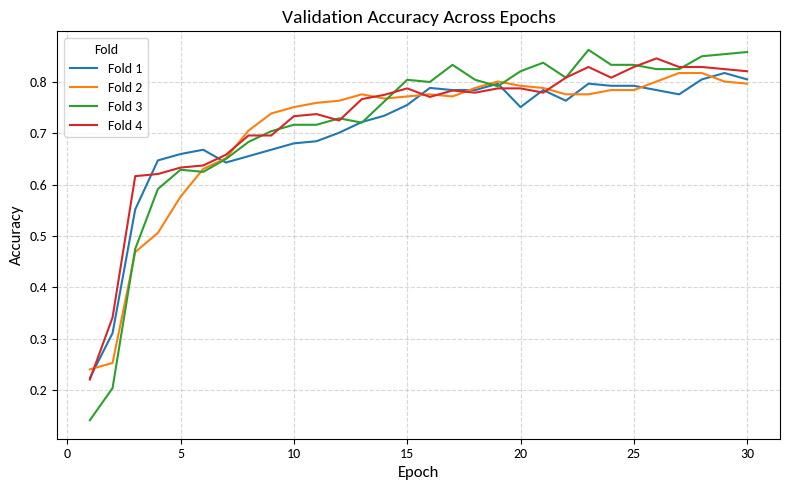

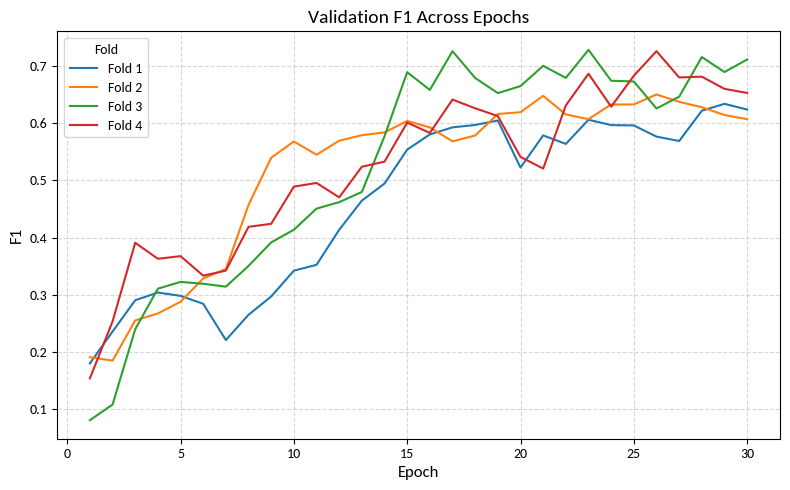

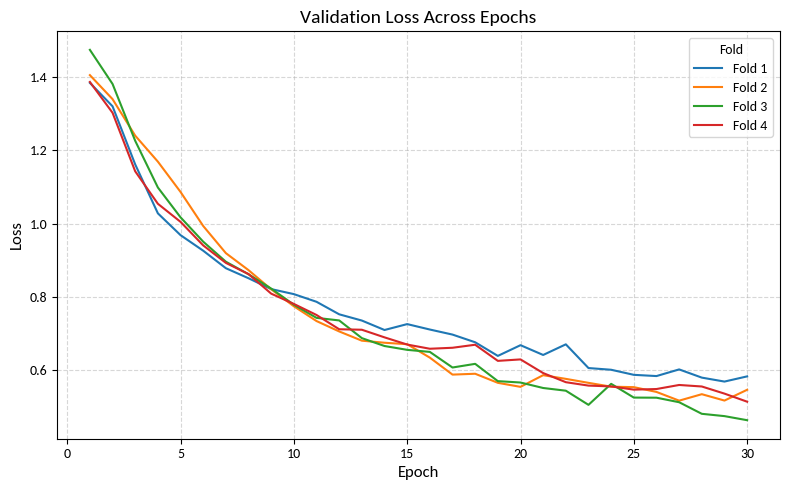

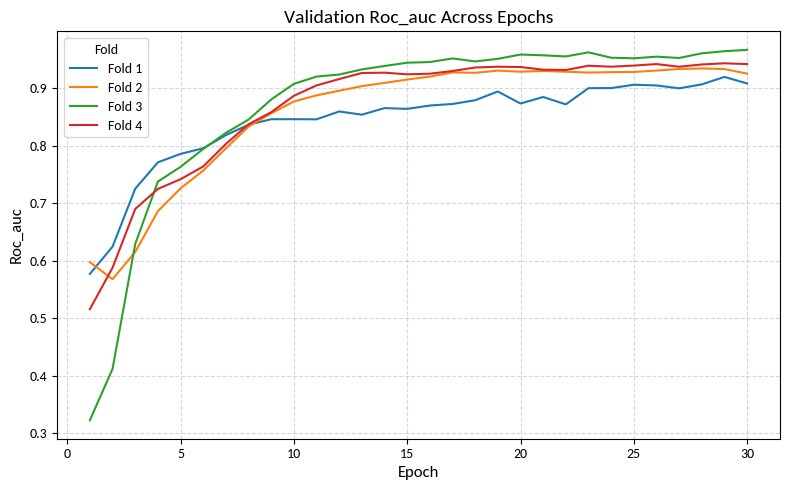

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# === ✅ Add Carlito font correctly ===
font_path = '/usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf'
fm.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Carlito'

# === Load all folds ===
dfs = []
for fold in range(1, 5):
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv')
    df['fold'] = fold
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# === Metrics you want ===
metrics = ['accuracy', 'f1', 'loss', 'roc_auc']

for metric in metrics:
    plt.figure(figsize=(8, 5))

    # Filter for overall only
    metric_df = full_df[(full_df['metric'] == metric) & (full_df['class'] == 'overall')]

    for fold in metric_df['fold'].unique():
        fold_df = metric_df[metric_df['fold'] == fold]
        plt.plot(fold_df['epoch'], fold_df['value'], label=f'Fold {fold}')

    plt.title(f'Validation {metric.capitalize()} Across Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title='Fold', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


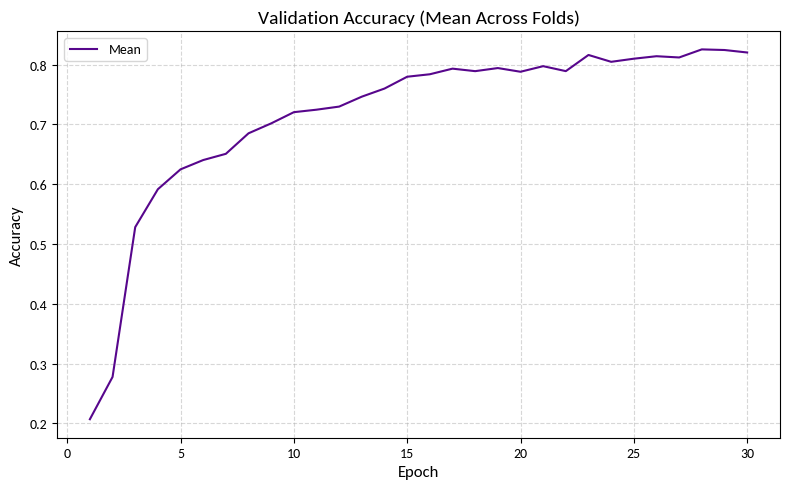

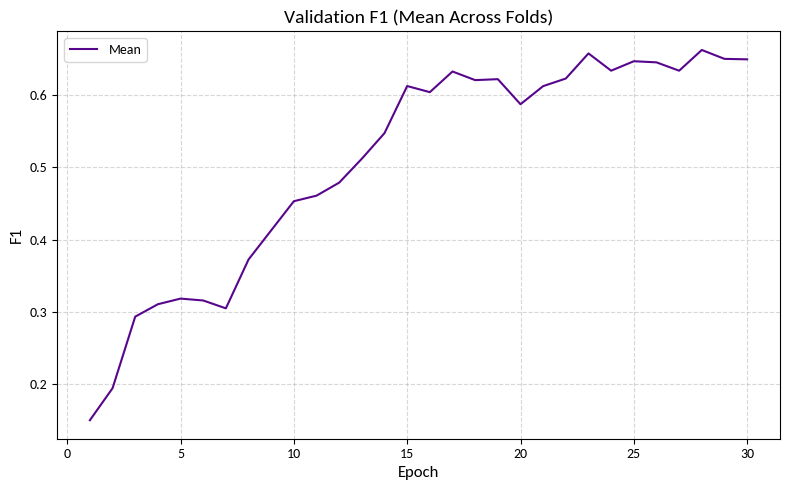

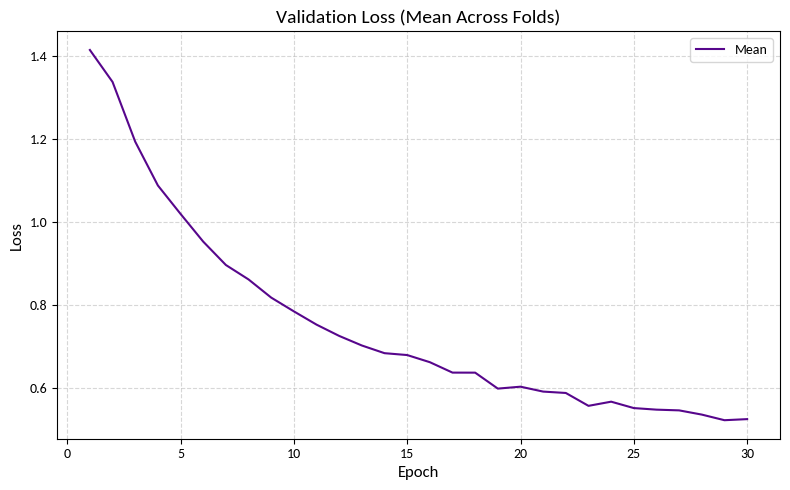

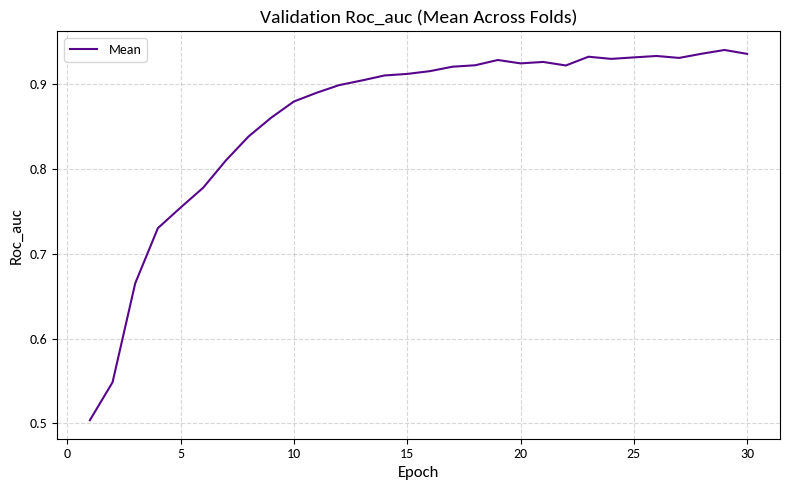

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# === ✅ Add Carlito font correctly ===
font_path = '/usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf'
fm.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Carlito'

# === Load all folds ===
dfs = []
for fold in range(1, 5):
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv')
    df['fold'] = fold
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# === Metric you want ===
metrics = ['accuracy', 'f1', 'loss', 'roc_auc']

# NYU purple color
nyu_purple = '#57068c'

for metric in metrics:
    plt.figure(figsize=(8, 5))

    metric_df = full_df[(full_df['metric'] == metric) & (full_df['class'] == 'overall')]
    mean_df = metric_df.groupby('epoch')['value'].mean().reset_index()

    plt.plot(
        mean_df['epoch'],
        mean_df['value'],
        '-',                  # solid line, no markers
        color=nyu_purple,
        label='Mean'
    )

    plt.title(f'Validation {metric.capitalize()} (Mean Across Folds)', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


##**Evaluation Metrics**

In [ ]:
import pandas as pd

# === Load all metrics ===
dfs = []
for fold in range(1, 5):
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv')
    df['fold'] = fold
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# === Filter only final epoch for each fold ===
# If you want best epoch per fold, you’d do:
# final_df = full_df.loc[full_df.groupby('fold')['epoch'].idxmax()]

# Here: get final epoch for each fold
fold_results = []

for fold in range(1, 5):
    fold_df = full_df[full_df['fold'] == fold]
    final_epoch = fold_df['epoch'].max()
    final_df = fold_df[fold_df['epoch'] == final_epoch]
    fold_results.append(final_df)

final_df = pd.concat(fold_results, ignore_index=True)

# === Keep only precision, recall, f1 for per-class ===
results = final_df[
    (final_df['metric'].isin(['precision', 'recall', 'f1'])) &
    (final_df['class'].isin(['NILM', 'LSIL', 'HSIL', 'SCC']))
]

# === Pivot to get [fold x metric] for each class ===
table = []
classes = ['NILM', 'LSIL', 'HSIL', 'SCC']
for class_name in classes:
    class_data = results[results['class'] == class_name].pivot(
        index='metric', columns='fold', values='value'
    )
    mean = class_data.mean(axis=1)
    std = class_data.std(axis=1)
    # You can skip std if you don’t want it
    table.append({
        'Class': class_name,
        'Precision': f"{mean['precision']:.5f}",
        'Recall': f"{mean['recall']:.5f}",
        'F1-score': f"{mean['f1']:.5f}",
        'Precision_std': f"{std['precision']:.5f}",
        'Recall_std': f"{std['recall']:.5f}",
        'F1-score_std': f"{std['f1']:.5f}"
    })

summary_df = pd.DataFrame(table)
print(summary_df)

# === Optional: save to CSV ===
summary_df.to_csv('/content/drive/My Drive/pap_smear/final_class_metrics_E.csv', index=False)


  Class Precision   Recall F1-score Precision_std Recall_std F1-score_std
0  NILM   0.88396  0.96405  0.92153       0.04172    0.01961      0.01619
1  LSIL   0.73318  0.70782  0.71785       0.08421    0.08488      0.07101
2  HSIL   0.64800  0.63796  0.63921       0.08724    0.09239      0.07324
3   SCC   0.77500  0.20322  0.31839       0.26300    0.03071      0.05556


In [ ]:
import pandas as pd

# === Load all metrics ===
dfs = []
for fold in range(1, 5):  # fix range to 1-6 if you have 5 folds!
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv')
    df['fold'] = fold
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# === Get final epoch for each fold ===
fold_results = []
for fold in range(1, 5):
    fold_df = full_df[full_df['fold'] == fold]
    final_epoch = fold_df['epoch'].max()
    final_df = fold_df[fold_df['epoch'] == final_epoch]
    fold_results.append(final_df)

final_df = pd.concat(fold_results, ignore_index=True)

# === Keep only per-class metrics ===
results = final_df[
    (final_df['metric'].isin(['precision', 'recall', 'f1'])) &
    (final_df['class'].isin(['NILM', 'LSIL', 'HSIL', 'SCC']))
]

# === Pivot, compute mean ± std, and format ===
table = []
classes = ['NILM', 'LSIL', 'HSIL', 'SCC']
for class_name in classes:
    class_data = results[results['class'] == class_name].pivot(
        index='metric', columns='fold', values='value'
    )
    mean = class_data.mean(axis=1)
    std = class_data.std(axis=1)

    table.append({
        'Class': class_name,
        'Precision': f"{mean['precision']:.3f} ± {std['precision']:.3f}",
        'Recall': f"{mean['recall']:.3f} ± {std['recall']:.3f}",
        'F1-score': f"{mean['f1']:.3f} ± {std['f1']:.3f}"
    })

summary_df = pd.DataFrame(table)
print(summary_df)

# === Optional: save for your paper ===
summary_df.to_csv('/content/drive/My Drive/pap_smear/final_class_metrics_formatted_E.csv', index=False)


  Class      Precision         Recall       F1-score
0  NILM  0.884 ± 0.042  0.964 ± 0.020  0.922 ± 0.016
1  LSIL  0.733 ± 0.084  0.708 ± 0.085  0.718 ± 0.071
2  HSIL  0.648 ± 0.087  0.638 ± 0.092  0.639 ± 0.073
3   SCC  0.775 ± 0.263  0.203 ± 0.031  0.318 ± 0.056


In [ ]:
import pandas as pd

# === Load all folds ===
dfs = []
for fold in range(1, 5):   # ✅ use 1–5 for 4 folds!
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/metrics/metrics_fold{fold}_E.csv')
    df['fold'] = fold
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# === Filter for overall only at final epoch ===
overall_results = []
for fold in range(1, 5):   # ✅ 4 folds!
    fold_df = full_df[full_df['fold'] == fold]
    final_epoch = fold_df['epoch'].max()
    final_df = fold_df[
        (fold_df['epoch'] == final_epoch) &
        (fold_df['class'] == 'overall') &
        (fold_df['metric'].isin(['accuracy', 'loss', 'precision', 'recall', 'f1', 'roc_auc']))
    ]
    overall_results.append(final_df)

overall_df = pd.concat(overall_results, ignore_index=True)

# === Compute mean ± SD for each metric ===
overall_table = []
metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1', 'roc_auc']
for metric in metrics:
    metric_vals = overall_df[overall_df['metric'] == metric]['value'].values
    mean_val = metric_vals.mean()
    std_val = metric_vals.std()
    overall_table.append({
        'Metric': metric.capitalize(),
        'Mean ± SD': f"{mean_val:.3f} ± {std_val:.3f}"
    })

summary_overall_df = pd.DataFrame(overall_table)

# ✅ Display
print(summary_overall_df)

# ✅ Optional: save
summary_overall_df.to_csv('/content/drive/My Drive/pap_smear/final_overall_metrics_formatted_E.csv', index=False)


      Metric      Mean ± SD
0   Accuracy  0.820 ± 0.024
1       Loss  0.526 ± 0.044
2  Precision  0.760 ± 0.081
3     Recall  0.628 ± 0.039
4         F1  0.649 ± 0.040
5    Roc_auc  0.936 ± 0.022


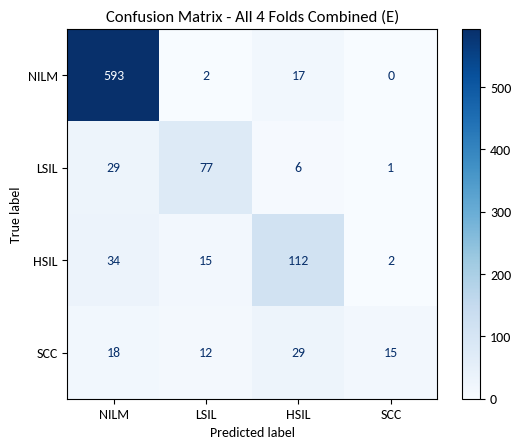

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Settings ===
folds = [1, 2, 3, 4]
class_names = ['NILM', 'LSIL', 'HSIL', 'SCC']
n_classes = len(class_names)

# === Initialize total confusion matrix
cm_total = np.zeros((n_classes, n_classes), dtype=int)

# === Loop through folds and sum up
for fold in folds:
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/preds/fold{fold}_preds_E.csv')
    y_true = df['true_label']
    y_pred = df['pred_label']
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_total += cm

# === Display combined confusion matrix
ConfusionMatrixDisplay(cm_total, display_labels=class_names).plot(
    cmap=plt.cm.Blues, values_format='d'
)
plt.title("Confusion Matrix - All 4 Folds Combined (E)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

folds = [1, 2, 3, 4]
class_names = ['NILM', 'LSIL', 'HSIL', 'SCC']
n_classes = len(class_names)

# === Store all folds ===
results = []

for fold in folds:
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/preds/fold{fold}_preds_E.csv')
    y_true = df['true_label']
    y_pred = df['pred_label']
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))

    # Per class:
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        results.append({
            'fold': fold,
            'class': class_name,
            'sensitivity': sensitivity,
            'specificity': specificity
        })

# === Make dataframe ===
sens_spec_df = pd.DataFrame(results)

print("\n🔍 Per class, per fold:")
print(sens_spec_df.head())

# === Compute mean ± SD across folds ===
summary = []
for class_name in class_names:
    class_df = sens_spec_df[sens_spec_df['class'] == class_name]

    sens_mean = class_df['sensitivity'].mean()
    sens_std = class_df['sensitivity'].std()

    spec_mean = class_df['specificity'].mean()
    spec_std = class_df['specificity'].std()

    summary.append({
        'class': class_name,
        'sensitivity': f"{sens_mean:.3f} ± {sens_std:.3f}",
        'specificity': f"{spec_mean:.3f} ± {spec_std:.3f}",
    })

summary_df = pd.DataFrame(summary)

print("\n✅ Mean ± SD across folds:")
print(summary_df)

# === Save if you want ===
sens_spec_df.to_csv('/content/drive/My Drive/pap_smear/sens_spec_per_fold_E.csv', index=False)
summary_df.to_csv('/content/drive/My Drive/pap_smear/sens_spec_mean_sd_E.csv', index=False)



🔍 Per class, per fold:
   fold class  sensitivity  specificity
0     1  NILM     0.973856     0.784091
1     1  LSIL     0.620690     0.957547
2     1  HSIL     0.650000     0.935323
3     1   SCC     0.210526     0.986486
4     2  NILM     0.967320     0.715909

✅ Mean ± SD across folds:
  class    sensitivity    specificity
0  NILM  0.969 ± 0.011  0.769 ± 0.038
1  LSIL  0.682 ± 0.094  0.966 ± 0.008
2  HSIL  0.687 ± 0.027  0.935 ± 0.019
3   SCC  0.203 ± 0.031  0.997 ± 0.007


In [ ]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

folds = [1, 2, 3, 4]

kappa_results = []

for fold in folds:
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/preds/fold{fold}_preds_E.csv')
    y_true = df['true_label']
    y_pred = df['pred_label']

    kappa = cohen_kappa_score(y_true, y_pred)
    kappa_results.append({'fold': fold, 'cohen_kappa': kappa})

kappa_df = pd.DataFrame(kappa_results)
print("\n✅ Cohen’s Kappa per fold:")
print(kappa_df)



✅ Cohen’s Kappa per fold:
   fold  cohen_kappa
0     1     0.645363
1     2     0.637036
2     3     0.720318
3     4     0.655242


In [ ]:
mean_kappa = kappa_df['cohen_kappa'].mean()
std_kappa = kappa_df['cohen_kappa'].std()

print(f"\n✅ Overall Cohen’s Kappa: {mean_kappa:.3f} ± {std_kappa:.3f}")

# Save if you like
kappa_df.to_csv('/content/drive/My Drive/pap_smear/cohen_kappa_per_fold_E.csv', index=False)
with open('/content/drive/My Drive/pap_smear/cohen_kappa_summary_E.txt', 'w') as f:
    f.write(f"Cohen’s Kappa mean ± SD: {mean_kappa:.3f} ± {std_kappa:.3f}\n")



✅ Overall Cohen’s Kappa: 0.664 ± 0.038


In [ ]:
import numpy as np

dfs = []
for fold in folds:
    df = pd.read_csv(f'/content/drive/My Drive/pap_smear/preds/fold{fold}_preds_E.csv')
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
y_true_all = combined_df['true_label']
y_pred_all = combined_df['pred_label']

kappa_overall = cohen_kappa_score(y_true_all, y_pred_all)
print(f"\n✅ Cohen’s Kappa (all folds combined): {kappa_overall:.3f}")



✅ Cohen’s Kappa (all folds combined): 0.664
